<a href="https://colab.research.google.com/github/ipeirotis/mturk_demographics/blob/master/6_demographics_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing

In [1]:
# Load the data and process it.
import pandas as pd
URL = 'https://github.com/ipeirotis/mturk_demographics/raw/master/dataset_29may2023_16_mar2015.zip'
df = pd.read_csv(URL, low_memory=False)

In [2]:
# df=df.dropna()
grouped_size = df.groupby(['worker_id','hit_answered_date','gender','household_income','household_size','location_country','time_spent_on_mturk','marital_status','year_of_birth']).transform('size')
# Map the group sizes to the original DataFrame based on index
df['count'] = grouped_size

# Display the dataset with the new "row_count" column
print(len(df['worker_id'].unique()))
print(df['count'].value_counts())

123508
1.0    207279
2.0       862
3.0        60
5.0         5
Name: count, dtype: int64


In [3]:
# Add a new column for 'worker_id' counts
df['participation'] = df['worker_id'].map(df['worker_id'].value_counts())
print(len(df['worker_id'].unique()))

123508


In [4]:
df= df[['worker_id','gender','household_income','household_size','location_country','marital_status','year_of_birth','time_spent_on_mturk','count','participation']]

#dem_df = df.drop_duplicates()
dem_df = df.drop_duplicates(subset=['worker_id'])

dem_df=dem_df.dropna()
print(len(dem_df))

87318


In [5]:
dem_df.head(5)

,worker_id,gender,household_income,household_size,location_country,marital_status,year_of_birth,time_spent_on_mturk,count,participation
0,GIQvi1p3x6/xUloDxpXza3DJKzO9QxtN0yPb49FMiY8=,male,"$25,000-$39,999",2,ZZ,married,1982.0,2-4 hours per week,1.0,4.0
1,OuVAI9jQUJ1TrM8tfCrr70KsearC0kNbovFD9prQ91M=,male,"$40,000-$59,999",3,ZZ,married,1930.0,2-4 hours per week,1.0,5.0
2,rXYK7nenLvxPYqFIOk9Ik5ALPFsXma+Lah1+1Ct+5y4=,female,"$40,000-$59,999",2,ZZ,single,1994.0,4-8 hours per week,1.0,4.0
3,ndej+ke5aXKdkZmPuI2Vz878ZjtyA4r2+7D4zA05Pvw=,male,"$75,000-$99,999",4,ZZ,married,1991.0,2-4 hours per week,1.0,25.0
4,E2skbsh2TBfWqeUSwFDajfQfJpMB2hqjKkzFh26W2PY=,female,"$75,000-$99,999",4,ZZ,married,1996.0,2-4 hours per week,1.0,21.0


In [6]:
from scipy.special import logit
import pandas as pd

## Regression against the demographics:
## DJ preprocessed the data using sql
## 1 worker per row: count
##    - count: number of identical rows
##    - participation: number of submissions
##  if count <> participation, worker changed his reponses (participation - count) times

# dem_df = pd.read_csv("demographics_preprocessed.csv")

dem_df["household_income"]=dem_df["household_income"].astype("category")
dem_df["household_size"]=dem_df["household_size"].astype("category")
dem_df["location_country"]=dem_df["location_country"].astype("category")
dem_df["marital_status"]=dem_df["marital_status"].astype("category")
dem_df["year_of_birth"]=dem_df["year_of_birth"].astype(int)
dem_df["time_spent_on_mturk"]=dem_df["time_spent_on_mturk"].astype("category")

dem_df['propensity'] = dem_df['participation']/29
dem_df['life_event'] = dem_df['count']!= dem_df['participation']
dem_df['life_event'] = dem_df['life_event'].apply(lambda x : 1 if x else 0)
dem_df['location_country'] = dem_df['location_country'].apply(lambda x : x if x in ['US','IN','CA','GB','PH'] else 'OTHER')
dem_df['age'] = 2023 - dem_df['year_of_birth']

len(dem_df)

87318

In [7]:
import math
import statsmodels.formula.api as sm

formula = "propensity ~ C(location_country) + C(gender) +  C(household_income)+ C(household_size) + C(marital_status) + C(time_spent_on_mturk)+ age + C(life_event)"

result = sm.ols(formula=formula, data=dem_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             propensity   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     731.5
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:33:31   Log-Likelihood:                 51696.
No. Observations:               87318   AIC:                        -1.033e+05
Df Residuals:                   87287   BIC:                        -1.030e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                 0.0247      0.005      4.850      0.000       0.015       0.035
C(location_country)[T.GB]                                -0.0047      0.005     -0.991      0.322      -0.014       0.005
C(location_country)[T.IN]                                 0.0756      0.004     18.973      0.000       0.068       0.083
C(location_country)[T.OTHER]                              0.0053      0.004      1.350      0.177      -0.002       0.013
C(location_country)[T.PH]                                 0.0296      0.016      1.842      0.065      -0.002       0.061
C(location_country)[T.US]                                 0.0018      0.004      0.496      0.620      -0.005       0.009
C(gender)[T.male]                                         0.0007      0.001      0.799      0.424      -0.001       0.003
C(household_income)[T.$100,000 or more]                   0.0177      0.002      7.414      0.000       0.013       0.022
C(household_income)[T.$15,000-$24,999]                    0.0059      0.002      2.469      0.014       0.001       0.011
C(household_income)[T.$25,000-$39,999]                    0.0088      0.002      4.018      0.000       0.004       0.013
C(household_income)[T.$40,000-$59,999]                    0.0061      0.002      2.906      0.004       0.002       0.010
C(household_income)[T.$60,000-$74,999]                    0.0108      0.002      4.826      0.000       0.006       0.015
C(household_income)[T.$75,000-$99,999]                    0.0131      0.002      5.874      0.000       0.009       0.017
C(household_income)[T.Less than $10,000]                  0.0047      0.003      1.860      0.063      -0.000       0.010
C(household_size)[T.2]                                   -0.0123      0.002     -6.698      0.000      -0.016      -0.009
C(household_size)[T.3]                                   -0.0194      0.002    -10.830      0.000      -0.023      -0.016
C(household_size)[T.4]                                   -0.0211      0.002    -11.625      0.000      -0.025      -0.018
C(household_size)[T.5 ]                                  -0.1152      0.134     -0.860      0.390      -0.378       0.147
C(household_size)[T.5+]                                  -0.0154      0.002     -7.242      0.000      -0.020      -0.011
C(marital_status)[T.divorced]                            -0.0031      0.004     -0.872      0.383      -0.010       0.004
C(marital_status)[T.engaged]                             -0.0105      0.003     -3.045      0.002      -0.017      -0.004
C(marital_status)[T.married]                             -0.0149      0.002     -6.766      0.000      -0.019      -0.011
C(marital_status)[T.single]      

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})

<Axes: ylabel='Frequency'>

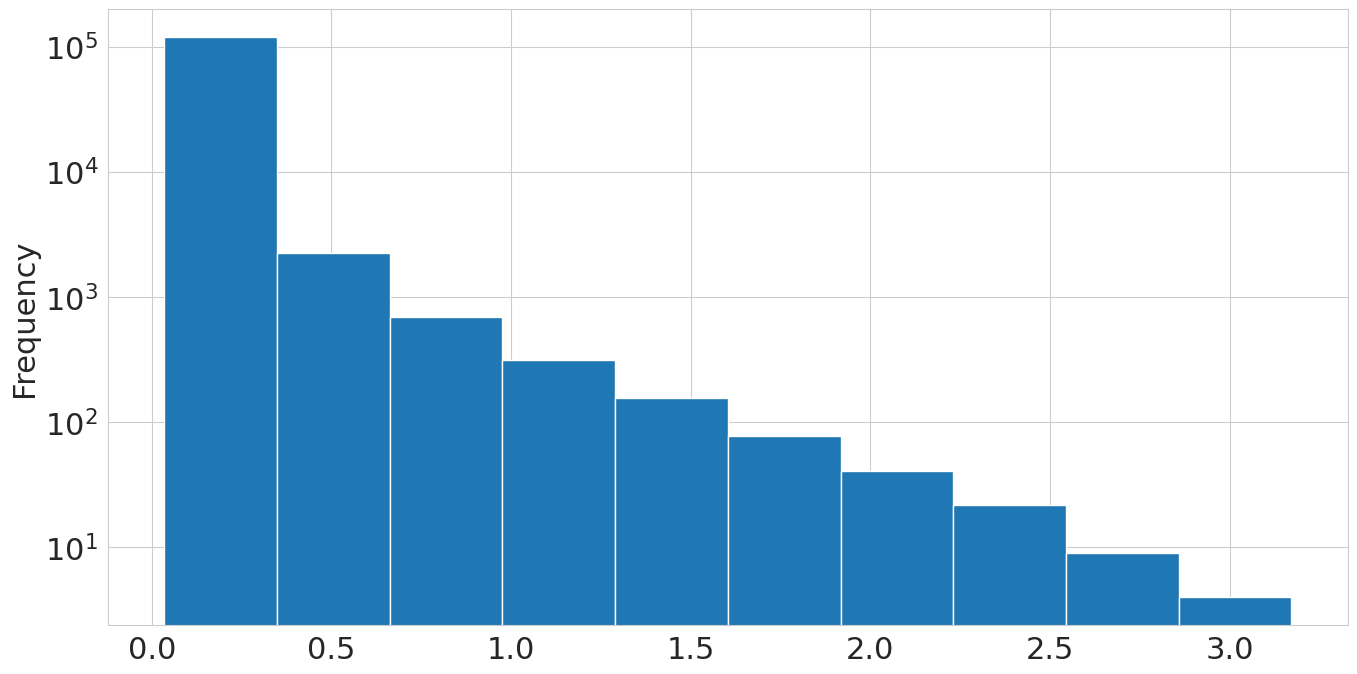

In [ ]:
dem_df.propensity.plot.hist(log=True)

In [10]:
len(dem_df[dem_df['propensity']<0.1])/len(dem_df)*100

81.36352183971232